In [1]:
from IPython.display import Image

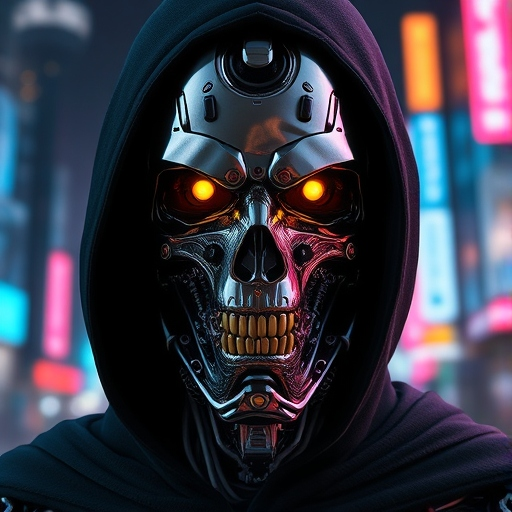

In [2]:
Image(filename = 'RENN.jpeg')

# Reverse Engineering a Neural Network

#### Inspired by Andrej Karpathy’s micrograd, this lecture builds a neural network from scratch, manually deriving gradients, automating backpropagation, and leveraging the TANH activation for nonlinearity. We bridge to PyTorch, demonstrating gradient descent’s power to minimize loss and reveal neural network fundamentals.

### [Original Video from Andrej Karpathy](https://youtu.be/VMj-3S1tku0?si=-Tzz2Y2-iv5FLDtY)

#### Credit: [Andrej Karpathy](mailto:karpathy@eurekalabs.ai)
#### Instructor: [Kevin Thomas](mailto:ket189@pitt.edu)

## Imports

In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Foundational Classes & Functions

In [4]:
class Value:
    """
    A class representing a scalar value in a computational graph.

    This class supports operations such as addition, subtraction, multiplication, 
    division, exponentiation, and hyperbolic tangent (tanh), along with automatic 
    differentiation through backpropagation. It is designed to build and manipulate 
    computational graphs for neural network computations.
    
    Attributes:
        data (float): The scalar value this object holds.
        grad (float): The gradient of this value with respect to some scalar loss.
        _backward (function): A function to compute the local gradient contribution during backpropagation.
        _prev (set[Value]): The set of `Value` objects that are inputs to this value.
        _op (str): The operation that produced this value (e.g., '+', '*', 'tanh', '**').
        label (str): A label for identifying the value (useful for visualization and debugging).
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initializes a `Value` object.

        Args:
            data (float): The scalar value to store.
            _children (tuple[Value], optional): The `Value` objects used to produce this value. Default is an empty tuple.
            _op (str, optional): The operation that produced this value. Default is an empty string.
            label (str, optional): A label for this value. Default is an empty string.
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """
        Returns a string representation of the `Value` object.

        Returns:
            str: A string showing the data value.
        """
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        """
        Defines the addition operation for `Value` objects.

        Args:
            other (Value): The other `Value` object to add.

        Returns:
            Value: A new `Value` object representing the sum of the two values.

        Note:
            The `_backward` method for the resulting value calculates the gradient contributions
            to both operands of the addition.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        """
        Defines the multiplication operation for `Value` objects.

        Args:
            other (Value): The other `Value` object to multiply.

        Returns:
            Value: A new `Value` object representing the product of the two values.

        Note:
            The `_backward` method for the resulting value calculates the gradient contributions
            to both operands of the multiplication.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        """
        Defines the power operation for `Value` objects.

        Args:
            other (int or float): The exponent to which the value is raised.

        Returns:
            Value: A new `Value` object representing the value raised to the power of `other`.

        Note:
            The `_backward` method for the resulting value calculates the gradient contribution
            for the power operation.
        """
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        """
        Defines right-side multiplication for `Value` objects.

        Args:
            other (float or Value): The value to multiply from the right.

        Returns:
            Value: A new `Value` object representing the product.
        """
        return self * other

    def __truediv__(self, other):
        """
        Defines division operation for `Value` objects.

        Args:
            other (Value): The divisor `Value` object.

        Returns:
            Value: A new `Value` object representing the division.

        Note:
            This is implemented as multiplying by the reciprocal.
        """
        return self * other**-1

    def __neg__(self):
        """
        Defines the negation operation for a `Value` object.

        Returns:
            Value: A new `Value` object representing the negated value.
        """
        return self * -1

    def __sub__(self, other):
        """
        Defines the subtraction operation for `Value` objects.

        Args:
            other (Value): The other `Value` object to subtract.

        Returns:
            Value: A new `Value` object representing the difference.
        """
        return self + (-other)

    def __radd__(self, other):
        """
        Defines right-side addition for `Value` objects.

        Args:
            other (float or Value): The value to add from the right.

        Returns:
            Value: A new `Value` object representing the sum.
        """
        return self + other

    def tanh(self):
        """
        Applies the hyperbolic tangent (tanh) function to the value.

        Returns:
            Value: A new `Value` object representing the tanh of this value.

        Note:
            The `_backward` method for the resulting value calculates the gradient contribution
            for the tanh function: `(1 - tanh(x)^2)`.
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        """
        Applies the exponential function to the value.

        Returns:
            Value: A new `Value` object representing the exponential of this value.

        Note:
            The `_backward` method for the resulting value calculates the gradient contribution
            for the exponential function: `e^x`.
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        """
        Performs backpropagation to calculate gradients for all `Value` objects in the computational graph.

        This method starts from the current `Value` object (usually the loss in a neural network) and
        propagates gradients to all dependent `Value` objects by traversing the computational graph in
        reverse topological order.

        Note:
            Sets the gradient of the starting value to 1.0 (i.e., the gradient of itself).
        """
        topo = []  # topological order of nodes
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [5]:
import platform

In [6]:
# check if the OS is macOS
if platform.system() == 'Darwin':
    !brew install graphviz
    !pip install graphviz

==> Downloading https://formulae.brew.sh/api/formula.jws.json
######################################################################### 100.0%
==> Downloading https://formulae.brew.sh/api/cask.jws.json
######################################################################### 100.0%
To reinstall 12.2.0, run:
  brew reinstall graphviz


In [7]:
from graphviz import Digraph

In [8]:
def trace(root):
    """
    Traces the computational graph starting from the given root node.

    This function builds a set of all nodes and edges in the computational graph
    by traversing backwards from the root node. It identifies all intermediate
    `Value` objects (nodes) and their relationships (edges) in the graph.

    Args:
        root (Value): The root node of the computational graph, typically the final output
                     (e.g., a loss value in a neural network).

    Returns:
        tuple:
            - nodes (set[Value]): A set of all `Value` objects in the computational graph.
            - edges (set[tuple[Value, Value]]): A set of directed edges representing the
              parent-child relationships in the graph.
    """
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    
    return nodes, edges


def draw_dot(root):
    """
    Creates a visual representation of the computational graph using the `graphviz` library.

    This function generates a directed graph (in DOT format) of the computational graph
    starting from the root node. Each node represents a `Value` object, and edges represent
    the operations connecting them.

    Args:
        root (Value): The root node of the computational graph, typically the final output
                     (e.g., a loss value in a neural network).

    Returns:
        graphviz.Digraph: A directed graph object representing the computational graph.

    Example:
        >>> from graphviz import Digraph
        >>> a = Value(2.0, label='a')
        >>> b = Value(-3.0, label='b')
        >>> c = Value(10.0, label='c')
        >>> e = a * b; e.label = 'e'
        >>> d = e + c; d.label = 'd'
        >>> f = Value(-2.0, label='f')
        >>> L = d * f; L.label = 'L'
        >>> dot = draw_dot(L)
        >>> dot.render('graph', format='svg', cleanup=True)
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right graph direction
    
    nodes, edges = trace(root)  # Trace the computational graph
    
    for n in nodes:
        uid = str(id(n))
        # for each value in the graph, create a rectangular ('record') node
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape='record'
        )
        if n._op:
            # if the value is a result of an operation, create an operation node
            dot.node(name=uid + n._op, label=n._op)
            # connect the operation node to the value node
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 (input) to the operation node of n2 (output)
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## Neural Network

In [9]:
Image(filename = 'nn.jpeg')

## Manual Feed-Forward (1st Epoch)

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

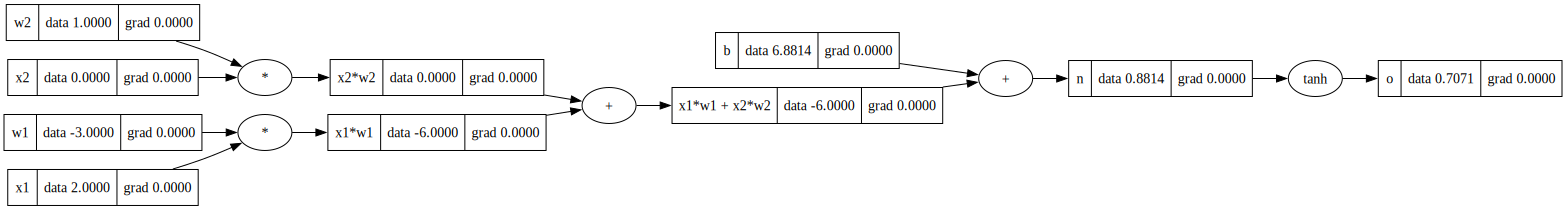

In [11]:
draw_dot(o)

## Manual Back Propogation (1st Epoch)

### `o` Gradient

In [12]:
o.grad = 1.0  # init back propogation

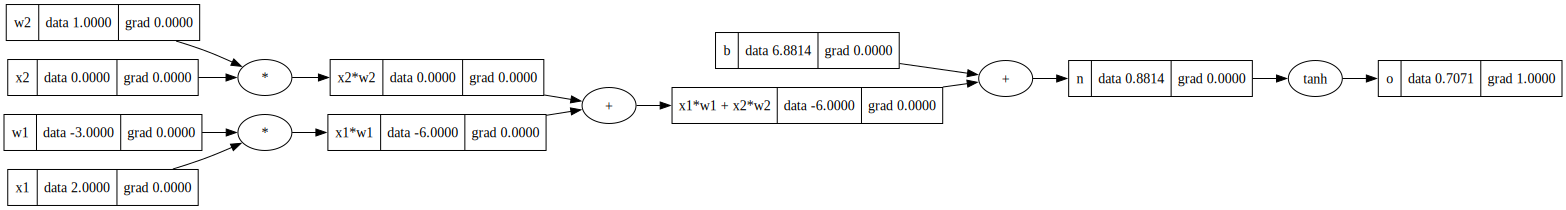

In [13]:
draw_dot(o)

### `n` Gradient

In [14]:
1 - o.data**2  # tanh

0.4999999999999999

In [15]:
n.grad = 0.5

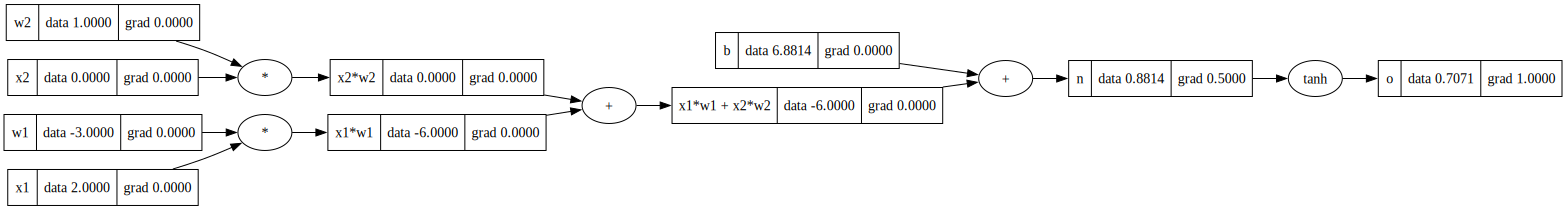

In [16]:
draw_dot(o)

### `x1*w1 + x2*w2` Gradient

#### We are working with a `+` node so therefore the `n.grad` of 0.5 will simply multiply by 1 or carry through.

In [17]:
x1w1x2w2.grad = 0.5

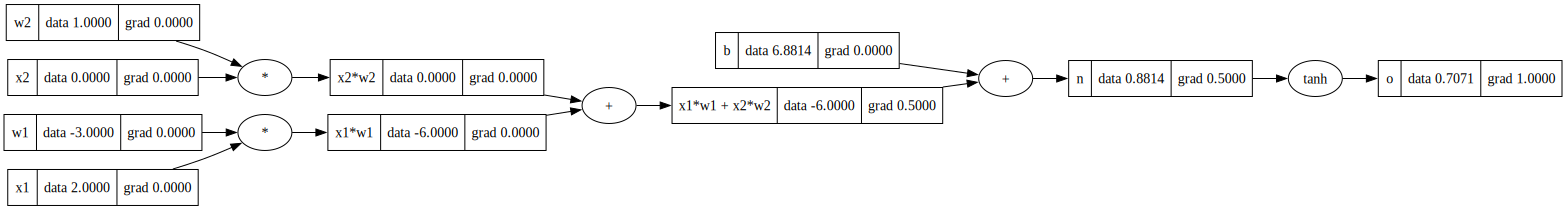

In [18]:
draw_dot(o)

### `b` Gradient

#### We are working with a `+` node so therefore the `n.grad` of 0.5 will simply multiply by 1 or carry through.

In [19]:
b.grad = 0.5

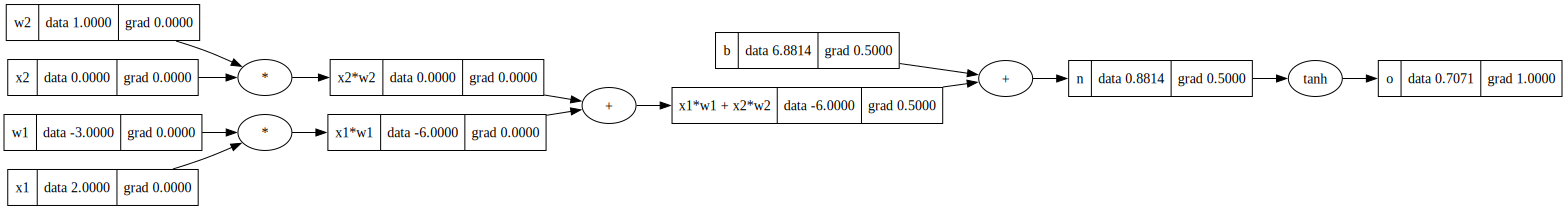

In [20]:
draw_dot(o)

### `x1*w1` Gradient

#### We are working with a `+` node so therefore the `x1w1x2w2.grad` of 0.5 will simply multiply by 1 or carry through.

In [21]:
x1w1.grad = 0.5

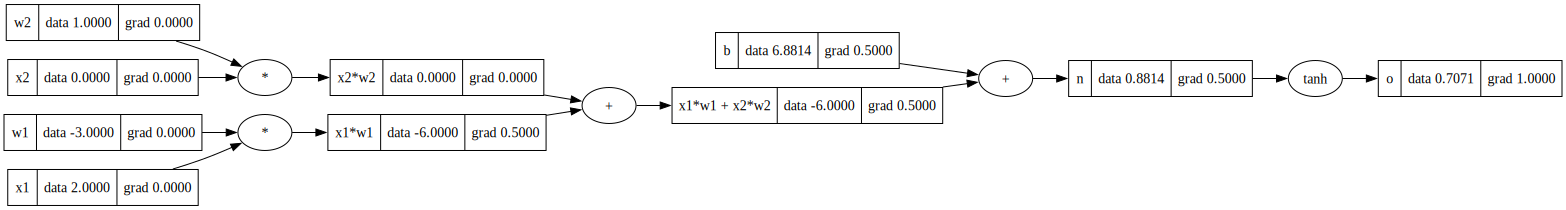

In [22]:
draw_dot(o)

### `x2*w2` Gradient

#### We are working with a `+` node so therefore the `x1w1x2w2.grad` of 0.5 will simply multiply by 1 or carry through.

In [23]:
x2w2.grad = 0.5

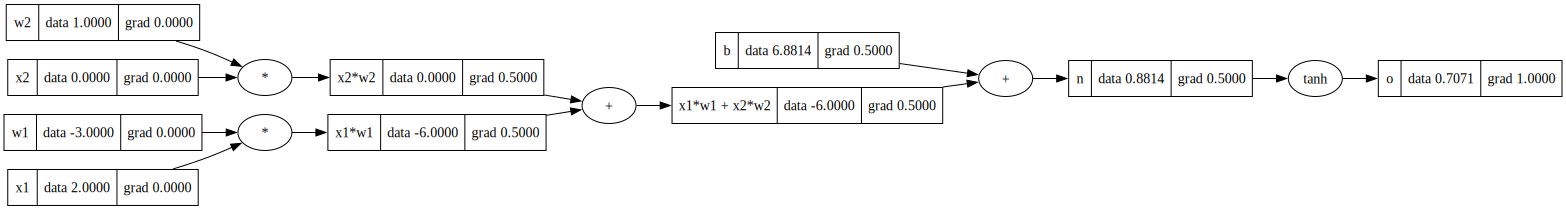

In [24]:
draw_dot(o)

### `x1` Gradient

#### We are working with a `*` node so therefore `x1.grad` will be `x1w1.grad * w1.data`. 

In [25]:
x1.grad = x1w1.grad * w1.data

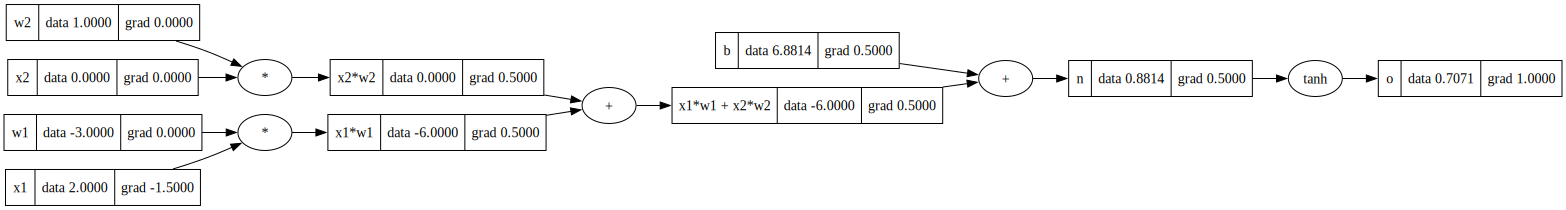

In [26]:
draw_dot(o)

### `w1` Gradient

#### We are working with a `*` node so therefore `w1.grad` will be `x1w1.grad * x1.data`. 

In [27]:
w1.grad = x1w1.grad * x1.data

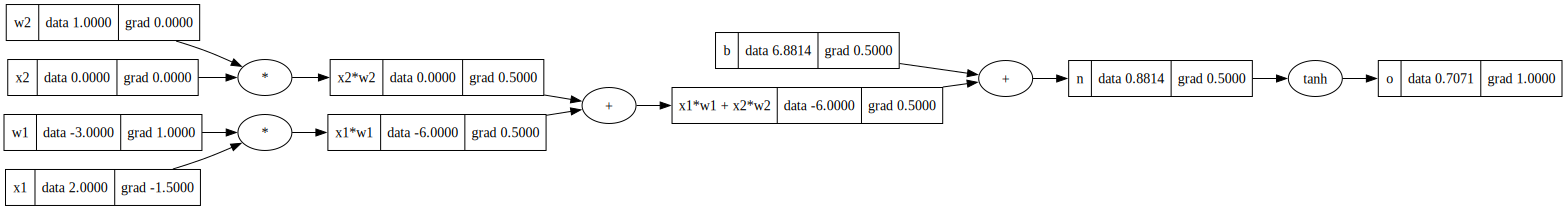

In [28]:
draw_dot(o)

### `x2` Gradient

#### We are working with a `*` node so therefore `x2.grad` will be `x2w2.grad * w2.data`. 

In [29]:
x2.grad = x2w2.grad * w2.data

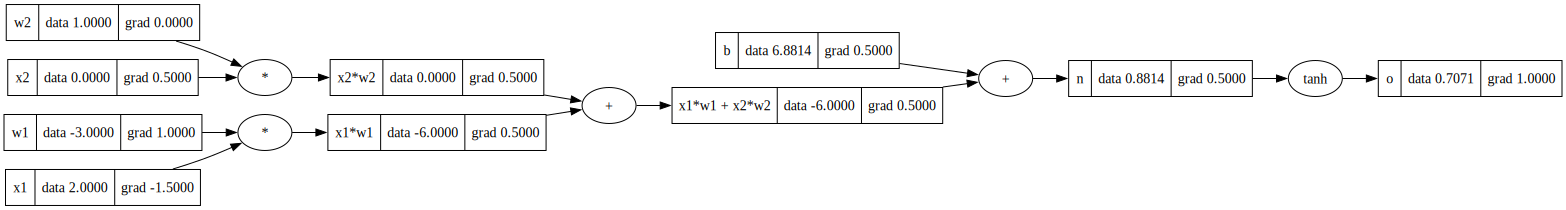

In [30]:
draw_dot(o)

### `w2` Gradient

#### We are working with a `*` node so therefore `w2.grad` will be `x2w2.grad * x2.data`. 

In [31]:
w2.grad = x2w2.grad * x2.data

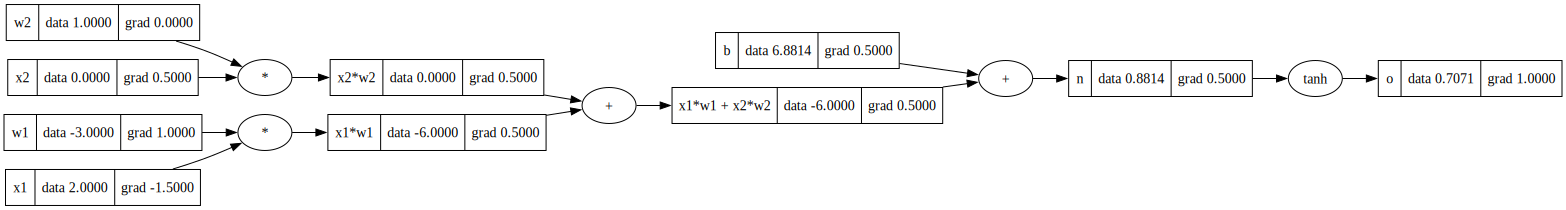

In [32]:
draw_dot(o)

## Manual Feed-Forward (1st Epoch)

In [33]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

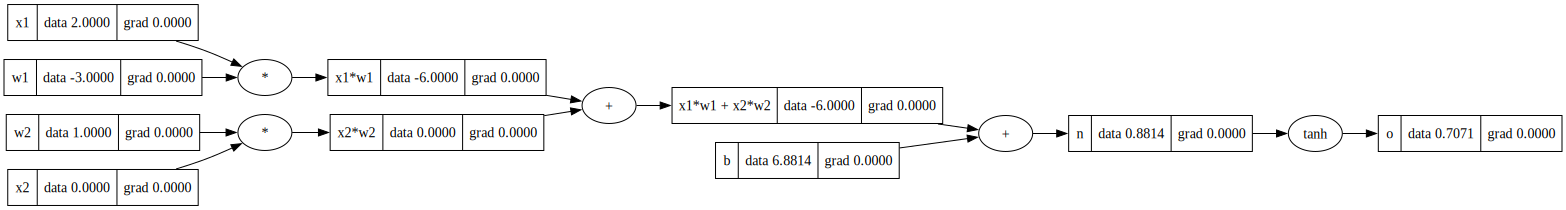

In [34]:
draw_dot(o)

## Back Propogation (1st Epoch)

In [35]:
o.grad = 1.0  # init back propogation

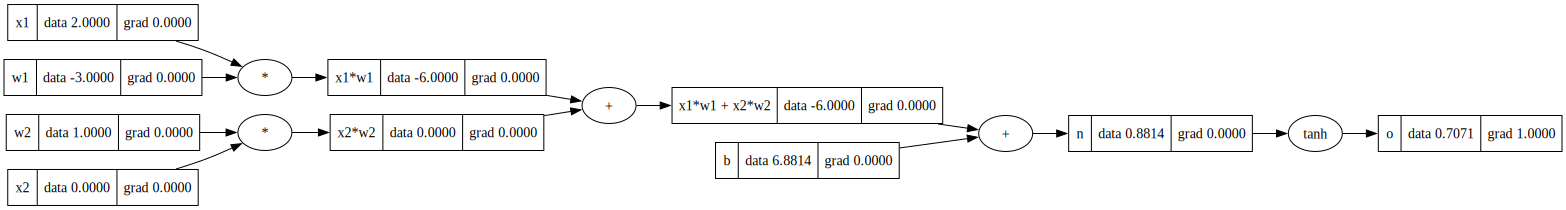

In [36]:
draw_dot(o)

### ALL Gradients

In [37]:
o.backward()

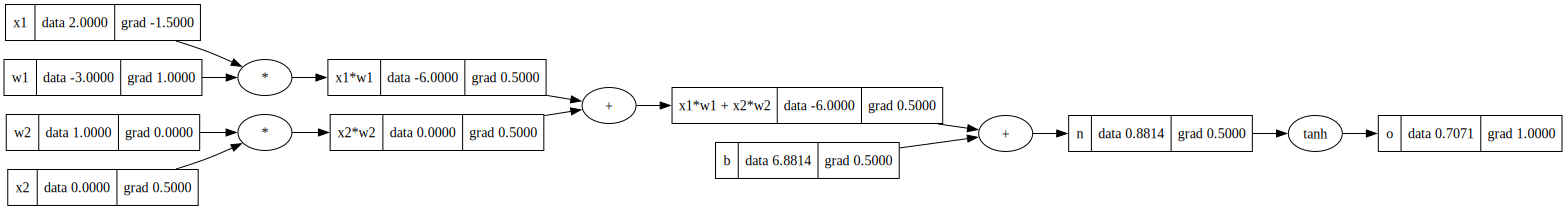

In [38]:
draw_dot(o)

## PyTorch Implementation

In [39]:
!pip install torch

In [40]:
import torch

In [41]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Minimizing Loss

In [42]:
# hyperparameters
learning_rate = 0.01  # learning rate for gradient descent
epochs = 100  # number of epochs

# target value for loss calculation (desired output for binary classifier)
target = torch.tensor([0.0], dtype=torch.double)

# training loop
for epoch in range(epochs):
    # forward pass
    n = x1 * w1 + x2 * w2 + b  # linear combination
    o = torch.tanh(n)  # activation function
    
    # loss calculation (Mean Squared Error for simplicity)
    loss = (o - target).pow(2) / 2  # MSE: L = (1/2) * (o - target)^2

    # backward pass
    loss.backward()  # compute gradients
    
    # gradient descent step (manual weight updates)
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        b -= learning_rate * b.grad

        # zero gradients for next iteration
        w1.grad.zero_()
        w2.grad.zero_()
        b.grad.zero_()
        x1.grad.zero_()
        x2.grad.zero_()
    
    # print loss for each epoch
    print(f'Epoch {epoch + 1}, Loss: {loss.item():.6f}, Output: {o.data.item():.6f}')

Epoch 1, Loss: 0.250000, Output: 0.707107
Epoch 2, Loss: 0.234693, Output: 0.685118
Epoch 3, Loss: 0.228050, Output: 0.675352
Epoch 4, Loss: 0.221271, Output: 0.665239
Epoch 5, Loss: 0.214365, Output: 0.654774
Epoch 6, Loss: 0.207342, Output: 0.643959
Epoch 7, Loss: 0.200214, Output: 0.632794
Epoch 8, Loss: 0.192996, Output: 0.621283
Epoch 9, Loss: 0.185704, Output: 0.609433
Epoch 10, Loss: 0.178355, Output: 0.597252
Epoch 11, Loss: 0.170967, Output: 0.584752
Epoch 12, Loss: 0.163562, Output: 0.571948
Epoch 13, Loss: 0.156161, Output: 0.558858
Epoch 14, Loss: 0.148786, Output: 0.545502
Epoch 15, Loss: 0.141461, Output: 0.531904
Epoch 16, Loss: 0.134209, Output: 0.518090
Epoch 17, Loss: 0.127053, Output: 0.504090
Epoch 18, Loss: 0.120018, Output: 0.489935
Epoch 19, Loss: 0.113125, Output: 0.475658
Epoch 20, Loss: 0.106397, Output: 0.461296
Epoch 21, Loss: 0.099852, Output: 0.446883
Epoch 22, Loss: 0.093510, Output: 0.432459
Epoch 23, Loss: 0.087387, Output: 0.418059
Epoch 24, Loss: 0.08